In [1]:
## Import Modules
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from datetime import datetime

import requests
from bs4 import BeautifulSoup

In [2]:
# Import `os` 
import os

# Retrieve current working directory (`cwd`)
cwd = os.getcwd()
cwd

# Change directory 
os.chdir("C:/Users/roand/Documents/Data Science Projects/2020_05 - DC COVID Data")

# List all files and directories in current directory
#os.listdir('.')

In [11]:

def read_in(date):
   
    #Getting weird connection time out issues + error in underlying raw data (instead of July 5 they have it recorded at June 5)
    #So I downloaded the file itself and manually corrected the date error
    
### GET LIST OF URLS ON DC WEBSITE
    url = "https://coronavirus.dc.gov/page/coronavirus-data"
    response = requests.get(url)
    # parse html
    page = str(BeautifulSoup(response.content))


    def getURL(page):
        """

        :param page: html of web page (here: Python home page) 
        :return: urls in that page 
        """
        start_link = page.find("a href")
        if start_link == -1:
            return None, 0
        start_quote = page.find('"', start_link)
        end_quote = page.find('"', start_quote + 1)
        url = page[start_quote + 1: end_quote]
        return url, end_quote

    list_url = []
    while True:
        url, n = getURL(page)
        page = page[n:]
        if url:
            list_url.append(url)
        else:
            break
        
### FIND CORRECT DOWNLOAD LINK FOR RELEVANT DATE
    # initializing substring 
    subs = date

    # to get string with substring  
    res = [i for i in list_url if subs in i] 

    # printing result  
    url_string = str(res)
    url_string = url_string.replace("['","")
    url_string = url_string.replace("']","")
    url_string = url_string.strip()
    print("URL String: " + url_string)

    start_str = url_string.find('DC-COVID-19-Updated-Data-for-')
    end_str = len(url_string)
    
    filename = url_string[start_str:end_str]
    print("File Name: " + filename)
    
### DOWNLOAD FILE
    dls = "https://coronavirus.dc.gov" + url_string
    print("DLS: " + dls)

    resp = requests.get(dls)
    #resp = requests.get(url_string)

    output = open('raw/'+filename, 'wb')
    output.write(resp.content)
    output.close()
    
### LOAD AND CLEAN FILE
    #xl = pd.ExcelFile('raw/' + filename)
    xl = pd.ExcelFile('raw/DC-COVID-19-Updated-Data-for-' + date + '.xlsx')

    # Print the sheet names
    #print("Sheet names: ", xl.sheet_names)
    
    df_data = xl.parse('Overal Stats')

    df_data = df_data.loc[df_data['Unnamed: 0'] == 'Testing']

    df_data = pd.melt(df_data,id_vars=['Unnamed: 1'],var_name='day',value_name='values')
    df_data = df_data.loc[df_data['day'] != 'Unnamed: 0']

    df_overall_test = df_data.loc[df_data['Unnamed: 1'] == 'Total Overall Number of Tests']
    df_total_positives = df_data.loc[df_data['Unnamed: 1'] == 'Total Positives']

    df_overall_test = df_overall_test[['day', 'values']]
    df_total_positives = df_total_positives[['day', 'values']] 

    df_overall_test.rename(columns = {'values':'overall_test'}, inplace = True) 
    df_total_positives.rename(columns = {'values':'total_positives'}, inplace = True) 

    df_data = pd.merge(df_total_positives,df_overall_test, on='day', how='inner')

    df_data['day'] = df_data['day'].astype(str)
    print(df_data)
    
    df_data['day'] = df_data['day'].apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

    df_data = df_data.sort_values(by=['day'],ascending=True)

    df_data['pct_positive'] = df_data['total_positives'] / df_data['overall_test']

    df_data.reset_index(level=0, inplace=True)
    df_data.set_index('day', drop=True, inplace=True)

    return df_data


In [13]:
### INPUT DATE HERE IN FORMAT 'MMMM-DD-YYYY'
df_merged = read_in('September-19-2020')



URL String: /sites/default/files/dc/sites/coronavirus/page_content/attachments/DC-COVID-19-Updated-Data-for-September-19-2020.xlsx
File Name: DC-COVID-19-Updated-Data-for-September-19-2020.xlsx
DLS: https://coronavirus.dc.gov/sites/default/files/dc/sites/coronavirus/page_content/attachments/DC-COVID-19-Updated-Data-for-September-19-2020.xlsx
                     day total_positives overall_test
0    2020-03-07 00:00:00               2          NaN
1    2020-03-08 00:00:00               2          NaN
2    2020-03-09 00:00:00               4          NaN
3    2020-03-10 00:00:00               4          NaN
4    2020-03-11 00:00:00              10          NaN
..                   ...             ...          ...
192  2020-09-15 00:00:00           14743       338241
193  2020-09-16 00:00:00           14790       341318
194  2020-09-17 00:00:00           14852       347118
195  2020-09-18 00:00:00           14902       350877
196  2020-09-19 00:00:00           14955       355144

[197 ro

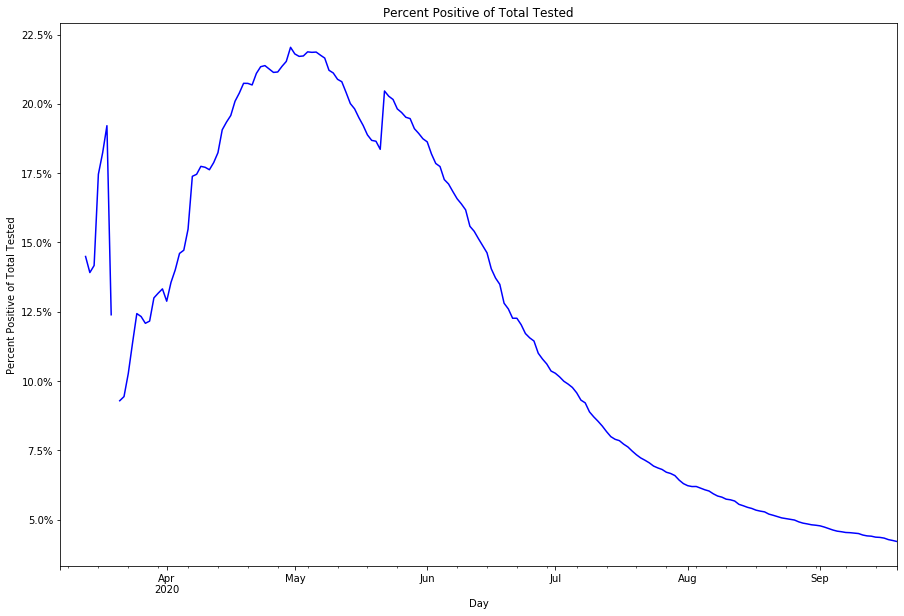

In [14]:
### BASIC PLOT

plt.rcParams['figure.figsize'] = [15, 10]

fig = df_merged.plot(use_index=True,
                                                   y='pct_positive',
                                                   title="Percent Positive of Total Tested",
                                                   color='Blue',
                                                   legend=False)


vals = fig.get_yticks()
fig.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

fig.set_ylabel("Percent Positive of Total Tested")
fig.set_xlabel("Day")

plt.show()


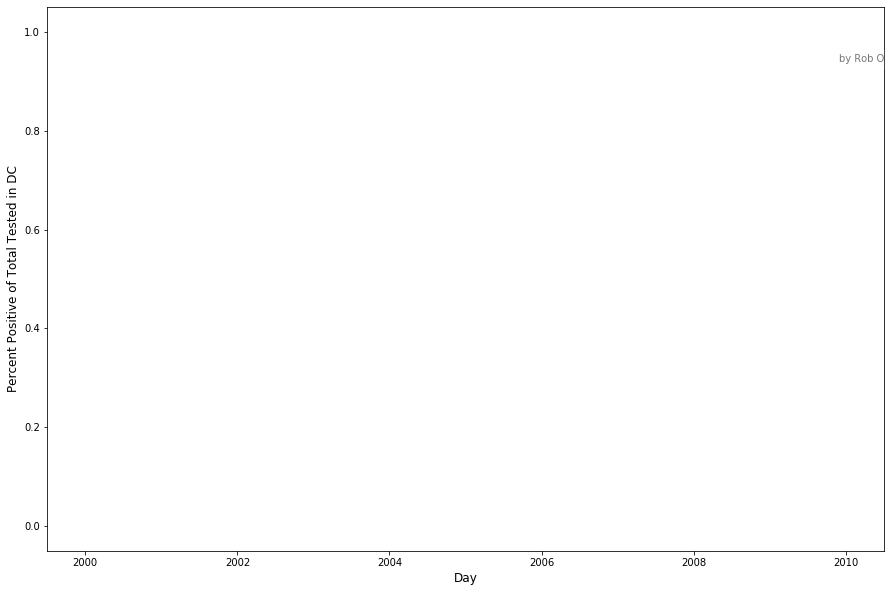

In [15]:
### ANIMATED PLOT

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# set a figure size:
fig = plt.figure(figsize=(15,10))
# set subplot grid parameters (1x1 grid, 1st subplot):
ax1 = fig.add_subplot(1,1,1)
# add limits on the x axis defined by the sample period (0 is the first observation, -1 the final observation):
ax1.axis(xmin = df_merged.index[0], xmax = df_merged.index[-1])
# add limits on the y-axis defined by minimum and maximum of the respective series, incorporate some additional room:
ax1.axis(ymin= (df_merged['pct_positive'].min()-0.1),ymax=(df_merged['pct_positive'].max()+0.1))


# define the function animate, which has the input argument of i:
def animate(i):
  #   set the variable data to contain 0 to the (i+1)th row:
  data =  df_merged.iloc[:int(i+1)]  #select data range
  #   initialise xp as an empty list:
  xp = []
  #   initialise yp as an empty list:
  yp = []
  
  # set the variable lines as equal to the variable data:
  lines = data

  #   for a line in lines:
  for line in lines:
    #     x is equal to the index (time domain):
    xp = data.index
    #     y is equal to the 'Henry Hub Continuous Futures' column
    yp = data['pct_positive']

  #   clear ax(1):
  ax1.clear()
  
  #   add a textbox in the top right corner (1, 0.9):
  ax1.text(1, 0.9, 'by Rob O', transform=ax1.transAxes, color='#777777', ha='right',
            bbox=dict(facecolor='white', alpha=0.1, edgecolor='white'))
  #   plot Henry Hub Continual Futures:
  ax1.plot(xp, yp)
  #   plot TTF Continual Futures:   
  #ax1.plot(xp, zp)

  #   provide a label for the x-axis:
  plt.xlabel('Day',fontsize=12)
  #   provide a label for the y-axis:  
  plt.ylabel('Percent Positive of Total Tested in DC',fontsize=12)
  #   provide a plot title:   
  #plt.title('Henry Hub vs TTF Futures',fontsize=14)


# call Matplotlib animation.Funcanimation, providing the input arguments of fig, animate, the number of frames and an interval:
ani = animation.FuncAnimation(fig, animate, frames = len(df_merged), interval=120) 
#ani = animation.FuncAnimation(fig, animate, frames=100)

# Use the 'ffmpeg' writer:|
Writer = animation.writers['ffmpeg']
# Set the frames per second and bitrate of the video:
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

HTML(ani.to_html5_video())

In [16]:
# Bokeh Libraries
from bokeh.io import output_notebook
from bokeh.plotting import ColumnDataSource, figure, output_file, show
from bokeh.models import NumeralTickFormatter
from bokeh.models.tools import HoverTool

output_notebook()

df_merged.reset_index(level=0, inplace=True)
df_merged[['day','total_positives','overall_test','pct_positive']]
df_merged.reset_index(drop=True, inplace=True)

source = ColumnDataSource(df_merged)

# Set up a  figure() object
fig = figure(title='Percent Positive of Total Tested in DC',
            plot_height=500,
            plot_width=1000,
            x_axis_type='datetime',
            x_axis_label='Day',
            y_axis_label='Percent Postive of Total Tested in DC',
            y_range=(0,.25),
            tools='pan,wheel_zoom,box_zoom,reset,previewsave')

fig.yaxis.formatter = NumeralTickFormatter(format="0%")



fig.add_tools(HoverTool(
    tooltips=[
        ('Day', '@day{%F}'),
        ('Pct Positive', '@pct_positive{0.0%}'),
        ('Total Positive', '@total_positives{0,0}'),
        ('Total Tested', '@overall_test{0,0}')
    ],
    formatters={
        '@day': 'datetime'},
    mode='vline'
))

#Line Graph
fig.line(x='day',
        y='pct_positive',
        line_width=2,
        source=source)


# See what it looks like
show(fig)

Loading BokehJS ...

In [8]:
### END OF CODE